<a href="https://colab.research.google.com/github/meheraj2325/Covid19-classification-using-chest-Xray/blob/master/covid19_classification_using_chest_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 Classification Using Chest Xray

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [4]:
!pip install livelossplot

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import PIL
from IPython.display import Image, display
# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go
import plotly.graph_objects as go
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model,load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,BatchNormalization,Activation
from keras.layers import GlobalMaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
import skimage.io
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
from livelossplot import PlotLossesKeras

In [6]:
from os import listdir
from os.path import isfile, join

#### Reading image files from the directories for each individual class and combine their filepath and classes into one dataframe.




In [7]:
# For 2nd dataset i.e. COVID-19 Image Detection-20200813T052115Z-001

image_dir_paths = {
    'covid19' : '/content/drive/My Drive/Colab-datasets/covit_dataSet/COVID-19 Image Detection-20200813T052115Z-001/COVID-19 Image Detection/COVID-19',
    'no_findings' : '/content/drive/My Drive/Colab-datasets/covit_dataSet/COVID-19 Image Detection-20200813T052115Z-001/COVID-19 Image Detection/No_findings',
    'pneumonia' : '/content/drive/My Drive/Colab-datasets/covit_dataSet/COVID-19 Image Detection-20200813T052115Z-001/COVID-19 Image Detection/Pneumonia'
}
print(image_dir_paths)

{'covid19': '/content/drive/My Drive/Colab-datasets/covit_dataSet/COVID-19 Image Detection-20200813T052115Z-001/COVID-19 Image Detection/COVID-19', 'no_findings': '/content/drive/My Drive/Colab-datasets/covit_dataSet/COVID-19 Image Detection-20200813T052115Z-001/COVID-19 Image Detection/No_findings', 'pneumonia': '/content/drive/My Drive/Colab-datasets/covit_dataSet/COVID-19 Image Detection-20200813T052115Z-001/COVID-19 Image Detection/Pneumonia'}


In [8]:
image_file_path_list = {
    'covid19' : [],
    'no_findings' : [],
    'pneumonia' : []
}
for class_name in image_dir_paths:
  dir_path = image_dir_paths[class_name]
  image_file_path_list[class_name] = [join(dir_path, f) for f in listdir(dir_path) if isfile(join(dir_path, f))]
  print(len(image_file_path_list[class_name]))

415
500
500


In [9]:
# 3 classes. 
# 0 for covid19
# 1 for no_findings
# 2 for pneumonia

class_value = {
    'covid19' : 0,
    'no_findings' : 1,
    'pneumonia' : 2
}

dataframe_for_each_class = {}
for class_name in image_file_path_list:
  df = pd.DataFrame({'filepath' : image_file_path_list[class_name]})
  df['label'] = class_value[class_name]
  print(df.head())
  print(df.shape)
  dataframe_for_each_class[class_name] = df

#print(dataframe_for_each_class)

                                            filepath  label
0  /content/drive/My Drive/Colab-datasets/covit_d...      0
1  /content/drive/My Drive/Colab-datasets/covit_d...      0
2  /content/drive/My Drive/Colab-datasets/covit_d...      0
3  /content/drive/My Drive/Colab-datasets/covit_d...      0
4  /content/drive/My Drive/Colab-datasets/covit_d...      0
(415, 2)
                                            filepath  label
0  /content/drive/My Drive/Colab-datasets/covit_d...      1
1  /content/drive/My Drive/Colab-datasets/covit_d...      1
2  /content/drive/My Drive/Colab-datasets/covit_d...      1
3  /content/drive/My Drive/Colab-datasets/covit_d...      1
4  /content/drive/My Drive/Colab-datasets/covit_d...      1
(500, 2)
                                            filepath  label
0  /content/drive/My Drive/Colab-datasets/covit_d...      2
1  /content/drive/My Drive/Colab-datasets/covit_d...      2
2  /content/drive/My Drive/Colab-datasets/covit_d...      2
3  /content/drive/My D

In [10]:
# combining three dataframes into one dataframe

whole_dataset = pd.concat([ dataframe_for_each_class[c] for c in dataframe_for_each_class], ignore_index=True)
print(whole_dataset.shape)
print(whole_dataset.info())
whole_dataset.head()

(1415, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1415 entries, 0 to 1414
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  1415 non-null   object
 1   label     1415 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.2+ KB
None


,filepath,label
0,/content/drive/My Drive/Colab-datasets/covit_d...,0
1,/content/drive/My Drive/Colab-datasets/covit_d...,0
2,/content/drive/My Drive/Colab-datasets/covit_d...,0
3,/content/drive/My Drive/Colab-datasets/covit_d...,0
4,/content/drive/My Drive/Colab-datasets/covit_d...,0


#### Before going any further with training let's take a look at sample chest xrays from each class.

Covid-19 Cases


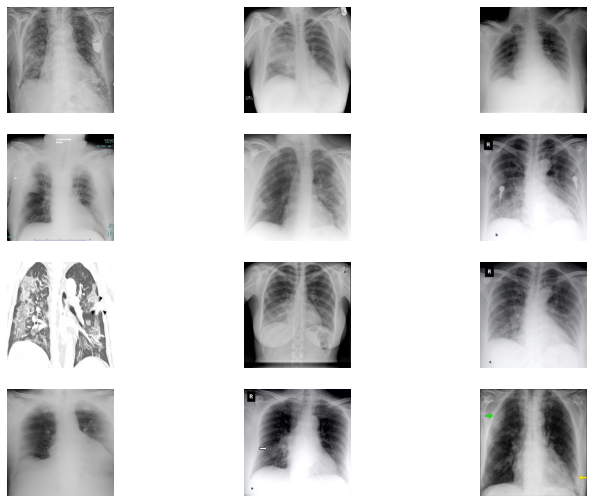

In [11]:
print('Covid-19 Cases')
covid19 = []
df_covid = dataframe_for_each_class['covid19'].sample(12)
df_covid = df_covid.reset_index()
for i in range(12):
    img = cv2.imread(str(df_covid['filepath'].iloc[i]))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    covid19.append(img)
f, ax = plt.subplots(4,3, figsize=(12,9))
for i, img in enumerate(covid19):
        ax[i//3, i%3].imshow(img)
        ax[i//3, i%3].axis('off')
        
plt.show()

No_findings Cases


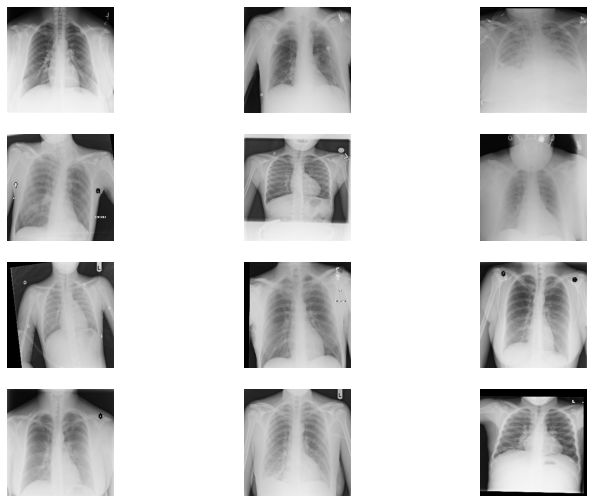

In [12]:
print('No_findings Cases')
no_findings = []
df_no_findings = dataframe_for_each_class['no_findings'].sample(12)
df_no_findings = df_no_findings.reset_index()
for i in range(12):
    img = cv2.imread(str(df_no_findings['filepath'].iloc[i]))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    no_findings.append(img)
f, ax = plt.subplots(4,3, figsize=(12,9))
for i, img in enumerate(no_findings):
        ax[i//3, i%3].imshow(img)
        ax[i//3, i%3].axis('off')
        
plt.show()

Pneumonia Cases


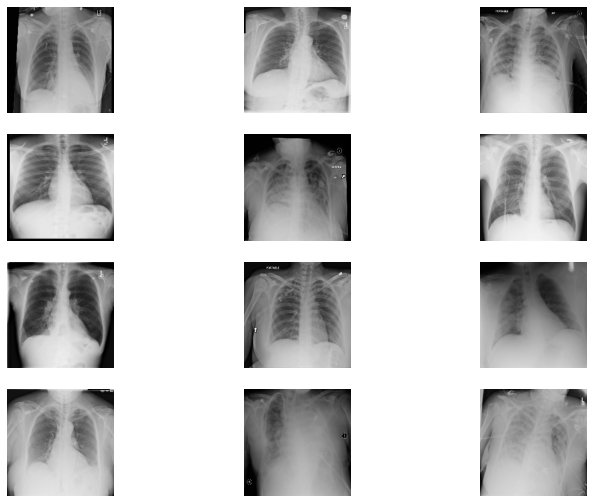

In [13]:
print('Pneumonia Cases')
pneumonia = []
df_pneumonia = dataframe_for_each_class['pneumonia'].sample(12)
df_pneumonia = df_pneumonia.reset_index()
for i in range(12):
    img = cv2.imread(str(df_pneumonia['filepath'].iloc[i]))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    pneumonia.append(img)
f, ax = plt.subplots(4,3, figsize=(12,9))
for i, img in enumerate(pneumonia):
        ax[i//3, i%3].imshow(img)
        ax[i//3, i%3].axis('off')
        
plt.show()

### Preparing the dataset
Dataset will be divided into three parts. 


*   Train set
*   Cross validation set
*   Test set





In [14]:
# # random_state is used to create reproducible results in train_test_split() 
# # so that everybody can consistently see the same numbers when they run the same line of code

# X_train, X_test, y_train, y_test = train_test_split(whole_dataset['filepath'], whole_dataset['label'], test_size = 0.2, random_state = 1234)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1234) # 0.25 x 0.8 = 0.2

# train = pd.DataFrame(X_train)
# train.columns = ['images']
# train['target'] = y_train

# validation = pd.DataFrame(X_val)
# validation.columns = ['images']
# validation['target'] = y_val

# test = pd.DataFrame(X_test)
# test.columns = ['images']
# test['target'] = y_test

# print("Train set : ", train.shape)
# print(train.head())
# print("\nValidation set : ", validation.shape)
# print(validation.tail())
# print("\nTest set : ", test.shape)
# print(test.head())

Dataset will be divided into two parts. 


*   Train set
*   Cross validation set





In [15]:
 # random_state is used to create reproducible results in train_test_split() 
# so that everybody can consistently see the same numbers when they run the same line of code

X_train, X_val, y_train, y_val = train_test_split(whole_dataset['filepath'], whole_dataset['label'], test_size = 0.2, random_state = 1234)

train = pd.DataFrame(X_train)
train.columns = ['images']
train['target'] = y_train

validation = pd.DataFrame(X_val)
validation.columns = ['images']
validation['target'] = y_val

print("Train set : ", train.shape)
print(train.head())
print("\nValidation set : ", validation.shape)
print(validation.tail())

Train set :  (1132, 2)
                                                 images  target
1351  /content/drive/My Drive/Colab-datasets/covit_d...       2
983   /content/drive/My Drive/Colab-datasets/covit_d...       2
123   /content/drive/My Drive/Colab-datasets/covit_d...       0
1289  /content/drive/My Drive/Colab-datasets/covit_d...       2
522   /content/drive/My Drive/Colab-datasets/covit_d...       1

Validation set :  (283, 2)
                                                 images  target
146   /content/drive/My Drive/Colab-datasets/covit_d...       0
1215  /content/drive/My Drive/Colab-datasets/covit_d...       2
643   /content/drive/My Drive/Colab-datasets/covit_d...       1
256   /content/drive/My Drive/Colab-datasets/covit_d...       0
1192  /content/drive/My Drive/Colab-datasets/covit_d...       2


#### Doing some very basic preprocessing like 
* normalizing
* reshaping
* augmentation(only for tarin data)

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 30,
    width_shift_range=0.2,
    height_shift_range=0.2, zoom_range=0.2)

val_datagen=ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    target_size=(299,299),
    batch_size=8,
    shuffle=True,
    class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(299,299),
    shuffle=False,
    batch_size=8,
    class_mode='raw')

Found 1132 validated image filenames.
Found 283 validated image filenames.


### Modelling
I'm using pretrained VGG-16 and adding some extra fully connected dense layer.

In [17]:
def create_model():

  base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(299,299,3))
    
  # train only the top layers (which were randomly initialized)
  # i.e. freeze all convolutional Xception layers
  for layer in base_model.layers:
    layer.trainable = False 
  
  x = Flatten()(base_model.output)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(.4)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(.3)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(.2)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dense(32, activation='relu')(x)
  x = Dense(16, activation='relu')(x)
  output=Dense(3,activation='softmax')(x)
  model=Model(base_model.input,output)
  
  return model

model = create_model()
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________

In [18]:
opt = Adam(lr=1e-5)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
no_epochs = 60
batch_size = 8
train_steps = train.shape[0]//batch_size
val_steps = validation.shape[0]//batch_size
print("Number of training and validation steps: {} and {}".format(train_steps,val_steps))

Number of training and validation steps: 141 and 35


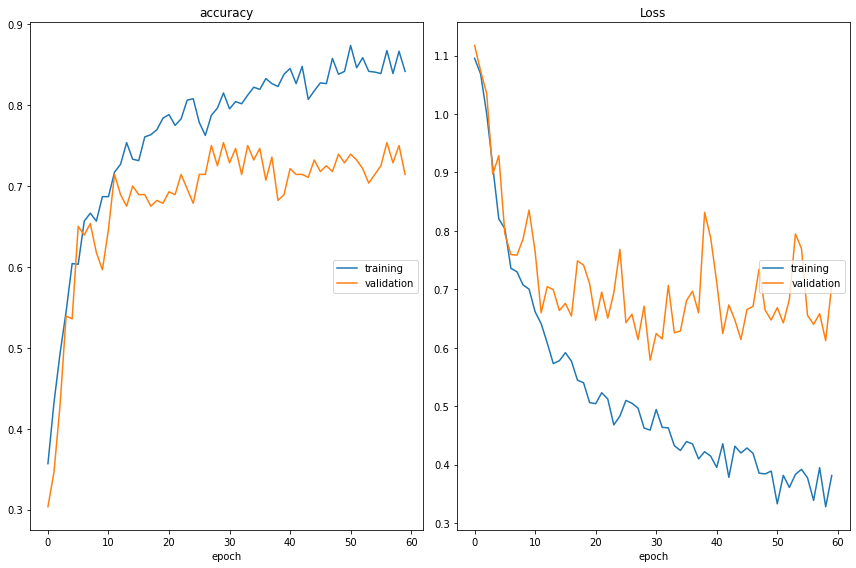

accuracy
	training         	 (min:    0.357, max:    0.874, cur:    0.842)
	validation       	 (min:    0.304, max:    0.754, cur:    0.714)
Loss
	training         	 (min:    0.328, max:    1.095, cur:    0.381)
	validation       	 (min:    0.579, max:    1.117, cur:    0.708)
141/141 [==============================] - 52s 370ms/step - loss: 0.3814 - accuracy: 0.8416 - val_loss: 0.7076 - val_accuracy: 0.7143


In [20]:
cb=[PlotLossesKeras()]
model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs= no_epochs,
    validation_data=validation_generator,
    callbacks=cb,
    validation_steps=val_steps)

In [ ]:
model.save('my_model.h5')